In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np

In [2]:
TRAIN_DATA_DIR = './cats_and_dogs_small/train'
VALIDATION_DATA_DIR = './cats_and_dogs_small/validation'
TEST_DATA_DIR = './cats_and_dogs_small/test'

TRAIN_SAMPLES = 800*2
VALIDATION_SAMPLES = 400*2 
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224 # image size for MobileNet
BATCH_SIZE = 64

아래와 같이 ImageDataGenerator 클래스를 사용해서 (학습데이터에 대해서) data augmentation 방법을 지정<br>
평가데이터나 검증데이터에 대해서는 수행하지 않음

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   # 셀의 값을 normalization
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# We don't augment data for validation dataset!

In [4]:
# train_datagen을 사용해서 학습 데이터를 불러옴, 실제 data augmentation이 이뤄짐
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
# val_datagen을 이용해서 검증 데이터를 불러옴
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 1600 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
model = MobileNet()

In [6]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [7]:
model1 = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

아래와 같이 model_maker()라고 하는 사용자 함수를 만들어서 새로운 모형을 구축함

In [8]:
def model_maker():
    # 일단 먼저 top 층을 제외한 사전학습 모형을 불러옴
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False 
        # 각 layer의 학습 여부 결정 => 기본값은 True로 되어 있음
        # 이번 예제에서는 모형의 구조만 변경, 파라미터는 새롭게 학습하지 않음
    # Input 클래스를 이용해서 입력 데이터의 형태를 지정
    input1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model) # 각 채널 (즉, 하나의 7x7 채널)에서 평균값 하나만 추출
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input1, outputs=predictions)

In [9]:
model_final = model_maker()
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,294,594
Trainable params: 65,730
Non-trainable params: 3,228,864
______________________________________________

In [10]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history = model_final.fit(
    train_generator, # 학습데이터를 불어오는 역할을 하는 train_generator를 첫번째 인자로 지정
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates, 1 epoch 당 업데이트 횟수를 지정
    epochs=20,
    validation_data=validation_generator, # 검증 데이터를 불러옴
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE)
# 이렇게 하면 ImageDataGenerator가 각 batch마다 random하게 BATCH_SIZE (=64)에 해당하는 이미지를 생성함

Epoch 1/20
25/25 [==============================] - 19s 775ms/step - loss: 0.4117 - acc: 0.8031 - val_loss: 0.0837 - val_acc: 0.9714
Epoch 2/20
25/25 [==============================] - 16s 647ms/step - loss: 0.2289 - acc: 0.9125 - val_loss: 0.0686 - val_acc: 0.9792
Epoch 3/20
25/25 [==============================] - 16s 640ms/step - loss: 0.1726 - acc: 0.9281 - val_loss: 0.0532 - val_acc: 0.9805
Epoch 4/20
25/25 [==============================] - 16s 633ms/step - loss: 0.1953 - acc: 0.9162 - val_loss: 0.0612 - val_acc: 0.9818
Epoch 5/20
25/25 [==============================] - 16s 638ms/step - loss: 0.1783 - acc: 0.9250 - val_loss: 0.0462 - val_acc: 0.9844
Epoch 6/20
25/25 [==============================] - 16s 637ms/step - loss: 0.1534 - acc: 0.9444 - val_loss: 0.0471 - val_acc: 0.9831
Epoch 7/20
25/25 [==============================] - 17s 689ms/step - loss: 0.1597 - acc: 0.9375 - val_loss: 0.0427 - val_acc: 0.9883
Epoch 8/20
25/25 [==============================] - 16s 635ms/step - 

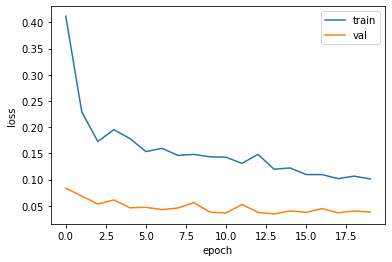

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

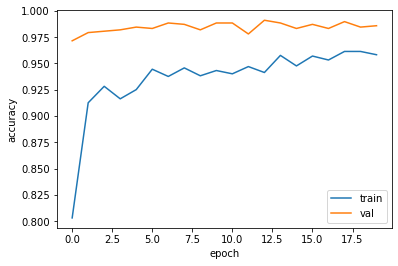

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 800 images belonging to 2 classes.


In [15]:
model_final.evaluate(test_generator, steps=800 // BATCH_SIZE,verbose=1)

12/12 [==============================] - 3s 243ms/step - loss: 0.0518 - acc: 0.9779


[0.051837313920259476, 0.9778645634651184]